Load data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



USE_MIXED = False
USE_PRESSURE_TEMP = False
noise_std_dev = 1e-3


if USE_MIXED:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_mixed.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_mixed.dat', 'fog_data_ir_water.dat']
else:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_water.dat']

target_i = 30 # Visibility
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))



data_ir_vis = []

for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])


# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.double)

nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)



X = np.zeros((data_ir_vis.shape[0], len(features_i)))
y = np.zeros(data_ir_vis.shape[0])

for i in range(len(data_ir_vis)):
  X[i] = data_ir_vis[i, features_i]
  y[i] = data_ir_vis[i,target_i]

# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(X))[0]
print(f'nani: {nan_i}')
X = np.delete(X, nan_i, axis=0)
y = np.delete(y, nan_i, axis=0)


# Scaling features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

X_scaled_noisy = X_scaled + np.random.normal(0, noise_std_dev, X_scaled.shape)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled_noisy, y_scaled, test_size=(1/20), random_state=16)

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19), random_state=16)

nani: []


NODE

In [16]:
from dataclasses import MISSING, dataclass, field
from typing import Any, Dict, Iterable, List, Optional
import os

def _validate_choices(cls):
    for key in cls.__dataclass_fields__.keys():
        atr = cls.__dataclass_fields__[key]
        if atr.init and "choices" in atr.metadata.keys():
            if getattr(cls, key) not in atr.metadata.get("choices"):
                raise ValueError(
                    f"{getattr(cls, key)} is not a valid choice for {key}."
                    f" Please choose from on of the following: {atr.metadata['choices']}"
                )

@dataclass
class DataConfig2:
    target: Optional[List[str]] = field(
        default=None,
        metadata={
            "help": "A list of strings with the names of the target column(s)."
            " It is mandatory for all except SSL tasks."
        },
    )
    continuous_cols: List = field(
        default_factory=list,
        metadata={"help": "Column names of the numeric fields. Defaults to []"},
    )
    batch_size: int = field(default=64, metadata={"help": "Number of samples in each batch of training"})
    data_aware_init_batch_size: int = field(
        default=2000,
        metadata={
            "help": "Number of samples in each batch of training for the data-aware initialization,"
            " when applicable. Defaults to 2000"
        },
    )
    task: str = field(default="classification",
        metadata={
            "help": "Specify whether the problem is regression or classification."
            " `backbone` is a task which considers the model as a backbone to generate features."
            " Mostly used internally for SSL and related tasks.",
            "choices": ["regression", "classification", "backbone"],
        }
    )
    categorical_cols: List = field(
        default_factory=list,
        metadata={"help": "Column names of the categorical fields to treat differently. Defaults to []"},
    )
    date_columns: List = field(
        default_factory=list,
        metadata={
            "help": "(Column names, Freq) tuples of the date fields. For eg. a field named"
            " introduction_date and with a monthly frequency like '2023-12' should have"
            " an entry ('intro_date','M','%Y-%m')"
        },
    )

    encode_date_columns: bool = field(
        default=True,
        metadata={"help": "Whether or not to encode the derived variables from date"},
    )
    validation_split: Optional[float] = field(
        default=0.2,
        metadata={
            "help": "Percentage of Training rows to keep aside as validation."
            " Used only if Validation Data is not given separately"
        },
    )
    continuous_feature_transform: Optional[str] = field(
        default=None,
        metadata={
            "help": "Whether or not to transform the features before modelling. By default it is turned off.",
            "choices": [
                None,
                "yeo-johnson",
                "box-cox",
                "quantile_normal",
                "quantile_uniform",
            ],
        },
    )
    normalize_continuous_features: bool = field(
        default=True,
        metadata={"help": "Flag to normalize the input features (continuous)"},
    )
    quantile_noise: int = field(
        default=0,
        metadata={
            "help": "NOT IMPLEMENTED. If specified fits QuantileTransformer on data with added gaussian noise"
            " with std = :quantile_noise: * data.std ; this will cause discrete values to be more separable."
            " Please not that this transformation does NOT apply gaussian noise to the resulting data,"
            " the noise is only applied for QuantileTransformer"
        },
    )
    num_workers: Optional[int] = field(
        default=0,
        metadata={"help": "The number of workers used for data loading. For windows always set to 0"},
    )
    pin_memory: bool = field(
        default=True,
        metadata={"help": "Whether or not to pin memory for data loading."},
    )
    handle_unknown_categories: bool = field(
        default=True,
        metadata={"help": "Whether or not to handle unknown or new values in categorical columns as unknown"},
    )
    handle_missing_values: bool = field(
        default=True,
        metadata={"help": "Whether or not to handle missing values in categorical columns as unknown"},
    )

    def __post_init__(self):
        assert (
            len(self.categorical_cols) + len(self.continuous_cols) + len(self.date_columns) > 0
        ), "There should be at-least one feature defined in categorical, continuous, or date columns"
        _validate_choices(self)
        if os.name == "nt" and self.num_workers != 0:
            print("Windows does not support num_workers > 0. Setting num_workers to 0")
            self.num_workers = 0

In [25]:
from pytorch_tabular import TabularModel, TabularDatamodule
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ModelConfig
from pytorch_tabular.models import NODEModel, NodeConfig
from pytorch_lightning import Trainer

#num_col_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26']

train_df = pd.DataFrame(X_train, columns=["feature_" + str(i) for i in range(X_train.shape[1])])
train_df['target'] = y_train

val_df = pd.DataFrame(X_val, columns=train_df.columns[:-1]) 
val_df['target'] = y_val

test_df = pd.DataFrame(X_test, columns=train_df.columns[:-1])
test_df['target'] = y_test

data_config = DataConfig2(
    target=["target"],
    continuous_cols=train_df.columns[:-1],
    #batch_size=64,
)

trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=64,
    max_epochs=100,
)

optimizer_config = OptimizerConfig()

model_config = NodeConfig(
    task="regression", # Since you're predicting visibility
    num_layers=8,
    num_trees=3,
)

#temp_dataset = TabularDatamodule(train_df, target="target", continuous_cols=train_df.columns[:-1]) 


config = {
    **data_config.__dict__,
    **model_config.__dict__,
    **trainer_config.__dict__,
    **optimizer_config.__dict__,
}


datamodule = TabularDatamodule(
    train=train_df,  # Training DataFrame 
    validation=val_df,      # Validation DataFrame
    config=data_config,
)


#inferred_config = data_config.get_inferred_config(datamodule) 




model = NODEModel(config=config)

trainer = Trainer(
    model=model, 
    data=datamodule,  # Pass the datamodule
    data_config=data_config, 
    trainer_config=trainer_config,  
)

trainer.fit() 

2024-03-04 10:26:09,722 - {pytorch_tabular.tabular_model:165} - INFO - Experiment Tracking is turned off

AttributeError: 'dict' object has no attribute 'task'

NODE 8-Layers

In [3]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import lib
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'year_node_8layers'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

in_features = X_train.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(X_train[:5000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0
experiment: year_node_8layers_2024.02.27_12:54


AttributeError: module 'lib' has no attribute 'DenseBlock'

TabNet Classifier PyTorch (Not finished)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier()

clf.fit(
  X_train, y_train, max_epochs=125,
  eval_set=[(X_val, y_val)]
)
preds = clf.predict(X_test)

plt.scatter(y_test, preds)
plt.xlabel("Actual Visibility")
plt.ylabel("Predicted Visibility")
plt.title("Predicted vs. Actual Visibility (Test Set)")
plt.show()

rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE on test set:", rmse)



TabNet Regressor Pytorch

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9943  | val_0_mse: 0.85736 |  0:00:03s
epoch 1  | loss: 0.84858 | val_0_mse: 0.83164 |  0:00:07s
epoch 2  | loss: 0.82038 | val_0_mse: 0.81551 |  0:00:11s
epoch 3  | loss: 0.79297 | val_0_mse: 0.79052 |  0:00:15s
epoch 4  | loss: 0.76587 | val_0_mse: 0.75056 |  0:00:19s
epoch 5  | loss: 0.75173 | val_0_mse: 0.81016 |  0:00:23s
epoch 6  | loss: 0.73885 | val_0_mse: 0.72168 |  0:00:27s
epoch 7  | loss: 0.72673 | val_0_mse: 0.76553 |  0:00:31s
epoch 8  | loss: 0.71865 | val_0_mse: 0.72647 |  0:00:35s
epoch 9  | loss: 0.7116  | val_0_mse: 0.70785 |  0:00:39s
epoch 10 | loss: 0.70274 | val_0_mse: 0.69751 |  0:00:43s
epoch 11 | loss: 0.69606 | val_0_mse: 0.71125 |  0:00:47s
epoch 12 | loss: 0.69027 | val_0_mse: 0.70751 |  0:00:51s
epoch 13 | loss: 0.68716 | val_0_mse: 0.69879 |  0:00:55s
epoch 14 | loss: 0.67746 | val_0_mse: 0.66875 |  0:00:59s
epoch 15 | loss: 0.67476 | val_0_mse: 0.6526  |  0:01:03s
epoch 16 | loss: 0.66832 | val_0_mse: 0.68555 |  0:01:07s
epoch 17 | los

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


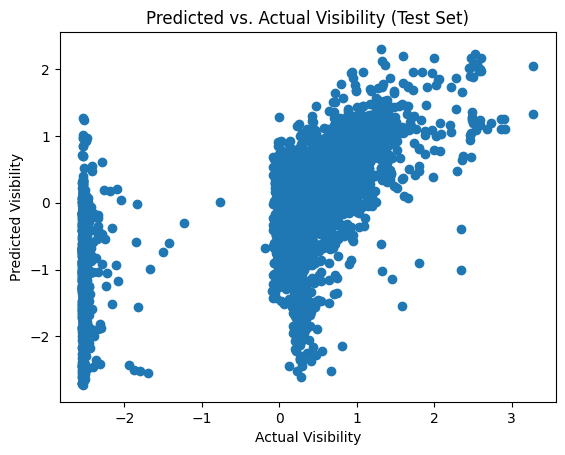

RMSE on test set: 0.7655265703752725


/home/edgelab/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

clf = TabNetRegressor()

clf.fit(
  X_train, y_train, max_epochs=45,
  eval_set=[(X_val, y_val)]
)
preds = clf.predict(X_test)

plt.scatter(y_test, preds)
plt.xlabel("Actual Visibility")
plt.ylabel("Predicted Visibility")
plt.title("Predicted vs. Actual Visibility (Test Set)")
plt.show()

rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE on test set:", rmse)



TabNet TensorFlow (Doesn't work)

In [20]:
from tabnet import TabNet, TabNetRegressor
import tensorflow as tf


model = TabNetRegressor(
    feature_columns=None,
    num_features=26,
    num_regressors=1,              # Because you have a single target variable
    feature_dim=X_train.shape[1],  # Automatically use the number of features
    output_dim=1,                  # Regression output dimension
    num_decision_steps=5,          # Experiment with this
    relaxation_factor=1.5,         # Experiment with this
    sparsity_coefficient=1e-5      # Adjust as needed
)

model.compile(
    optimizer='adam', 
    loss='mse',
    metrics=['rmse']
)

model.fit(X_train, y_train, epochs=200, batch_size = 128, validation_data=(X_val, y_val))

# Evaluate on the held-out test set
predictions_scaled = model.predict(X_test)
predictions = target_scaler.inverse_transform(predictions_scaled)  # Inverse scaling

rmse = mean_squared_error(y_test, predictions, squared=False)
print("RMSE on test set:", rmse)

plt.scatter(y_test, predictions)
plt.xlabel("Actual Visibility")
plt.ylabel("Predicted Visibility")
plt.title("Predicted vs. Actual Visibility (Test Set)")
plt.show()

explain_matrix, masks = model.explain(X_test)
fig, axs = plt.subplots(1, len(explain_matrix), figsize=(20, 5))
for i in range(len(explain_matrix)):
    axs[i].imshow(explain_matrix[i])
    axs[i].set_title(f"Feature Importances for Sample {i}")
plt.show()


[TabNet]: 25 features will be used for decision steps.
Epoch 1/200


ValueError: Exception encountered when calling TabNet.call().

[1m`add_loss()` can only be called from inside `build()` or `call()`, on a tensor input. Received invalid value: 0.0[0m

Arguments received by TabNet.call():
  • inputs=tf.Tensor(shape=(None, 26), dtype=float32)
  • training=True

Add noise (not done)

In [ ]:
bands_snr = [128, 201, 243, 228, 74, 275, 110, 880, 838, 802, 754, 750, 910, 1087, 586, 516, 167, 57, 250,
        None, None, None, None, None, None, 150, None, None, None, None, None, None, None, None, None, None]

bands_netd = [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,
         None, None, 0.05, 0.2, 0.07, 0.07, 0.25, 0.25, None, 0.25, 0.25, 0.05, 0.25, 0.05, 0.05, 0.25, 0.25, 0.25, 0.35]


snr_netd = zip(bands_snr, bands_netd)
all_bands = data_ir_vis[:,1:30]
print(all_bands[0,:])

print(all_bands.shape)

for band_i, (snr, netd) in enumerate(snr_netd):
    if snr != None:
        avg_squared_signal_pwr = np.mean(np.square(all_bands[:, band_i]))
        noise_std = np.sqrt(avg_squared_signal_pwr / snr)
    else:
        noise_std = netd
        
    all_bands[:, band_i] += np.random.normal(0, noise_std, all_bands[:, band_i].shape)

In [2]:
data_ir_vis = []

for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

Random Forest Regressor

Mean Squared Error: 0.6095084804742185


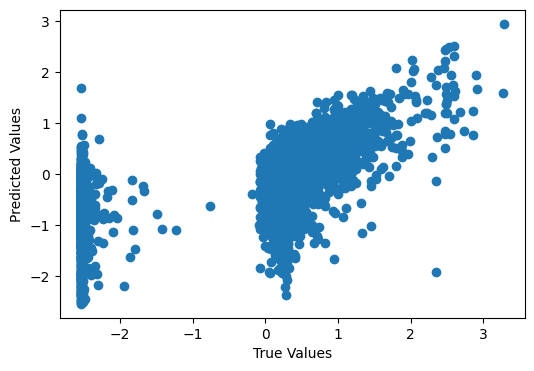

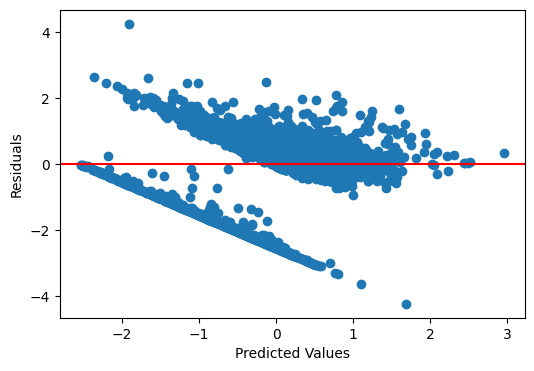

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.ravel())

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


Gradient Boosting Regressor

Mean Squared Error: 0.6867297042456644


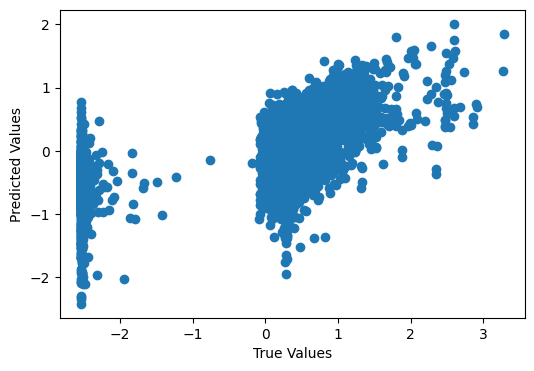

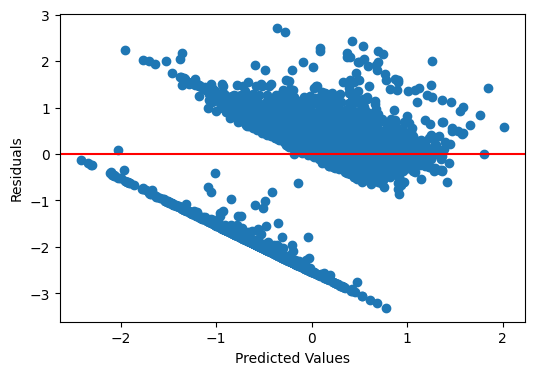

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train.ravel())

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

DNN

In [3]:
import tensorflow as tf
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()


history = ff_model.fit(X_train, y_train, epochs = 2000, batch_size = 128, validation_data=(X_val, y_val))

Epoch 1/2000
1055/1055 [==============================] - 6s 4ms/step - loss: 1.0037 - mean_absolute_error: 0.6160 - val_loss: 0.8697 - val_mean_absolute_error: 0.6214
Epoch 2/2000
1055/1055 [==============================] - 4s 4ms/step - loss: 0.8387 - mean_absolute_error: 0.5917 - val_loss: 0.8057 - val_mean_absolute_error: 0.5584
Epoch 3/2000
1055/1055 [==============================] - 4s 4ms/step - loss: 0.8065 - mean_absolute_error: 0.5781 - val_loss: 0.7958 - val_mean_absolute_error: 0.5623
Epoch 4/2000
1055/1055 [==============================] - 5s 4ms/step - loss: 0.7842 - mean_absolute_error: 0.5652 - val_loss: 0.7799 - val_mean_absolute_error: 0.5293
Epoch 5/2000
1055/1055 [==============================] - 5s 4ms/step - loss: 0.7738 - mean_absolute_error: 0.5583 - val_loss: 0.7606 - val_mean_absolute_error: 0.5445
Epoch 6/2000
1055/1055 [==============================] - 4s 4ms/step - loss: 0.7612 - mean_absolute_error: 0.5499 - val_loss: 0.7567 - val_mean_absolute_error:

In [1]:
y_pred = ff_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test - y_pred 

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 8 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

NameError: name 'ff_model' is not defined

QRNN

In [3]:
import keras
from quantnn import QRNN

# Model setup
model = QRNN(quantiles=[0.1, 0.5, 0.9], n_inputs=len(features_i))  # Estimate 10th, 50th, 90th percentiles

# Model fitting
model.train(X_train, y_train, epochs=100)

# Predictions
predictions = model.predict(X_test) 
print(predictions)

2024-02-22 09:59:13.967444: W external/local_tsl/tsl/lib/monitoring/collection_registry.cc:81] Trying to register 2 metrics with the same name: /tensorflow/api/oss-keras/optimizers. The old value will be erased in order to register a new one. Please check if you link the metric more than once, or if the name is already used by other metrics.


TypeError: api_export.__init__() got an unexpected keyword argument 'metaclass'

In [10]:
from typhon.retrieval.qrnn.qrnn import QRNN

# 2. Create QRNN Model (Same as before)
model = QRNN(
    quantiles=[0.1, 0.5, 0.9],  
    input_dimensions=X_train.shape[1],
    model=(3, 128, 'relu'),
    initial_learning_rate = 0.01
)

training_data = (X_train, y_train)
validation_data = (X_val, y_val)

# 3. Train the Model (Updated)
model.train(training_data, validation_data, batch_size=32) 

/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Argument(s) not recognized: {'lr': 0.01}